In [1]:
pip install pandas numpy scikit-learn matplotlib

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


**Download Ask & Bid datasets
The datasets (XAGUSD_5 Mins_Bid and XAGUSD_5 Mins_Ask) are loaded using:**

In [5]:
# Load and preprocess the dataset
bid_df = pd.read_csv('XAGUSD_5 Mins_Bid_2023.01.01_2023.06.30.csv')
ask_df = pd.read_csv('XAGUSD_5 Mins_Ask_2023.01.01_2023.06.30.csv')

**Merge Ask and Bid datasets 
The datasets are merged on the Time (UTC) column:**

In [7]:
# Merge datasets on Time (UTC)
merged_df = pd.merge(bid_df, ask_df, on='Time (UTC)', suffixes=('_Bid', '_Ask'))
merged_df['Time (UTC)'] = pd.to_datetime(merged_df['Time (UTC)'])


**Plot price and volume charts 
The Bid Close and Ask Close prices are visualized:**

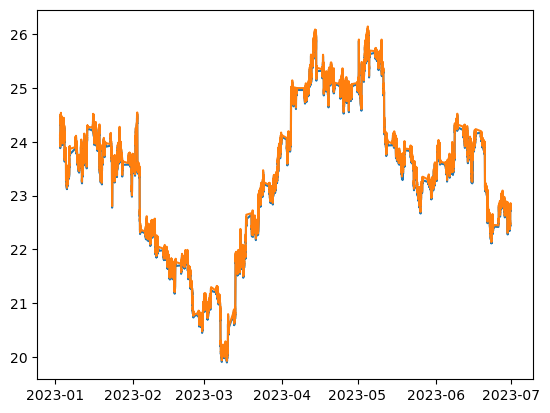

In [41]:
plt.plot(merged_df['Time (UTC)'], merged_df['Close_Bid'], label='Bid Close')
plt.plot(merged_df['Time (UTC)'], merged_df['Close_Ask'], label='Ask Close')


**Normalize data if necessary 
The data is normalized using MinMaxScaler:**

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

__Steps executed__

Shift the Min & Max prices 
A sliding window technique is used to predict the next price by shifting data:

Separate Inputs and Outputs matrices 

Create a 3D tensor 


In [48]:
def create_sequences(data, n_steps=5):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 10

X, y = create_sequences(scaled_data, n_steps)
X = X.reshape((X.shape[0], X.shape[1], 1))  # 3D tensor for CNN and LSTM

**Create and train neural networks (MLP, CNN and LTSM)**

In [13]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test)
    mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
    mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
    return mse, mae, y_pred_rescaled, y_test_rescaled

results = {}

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM

In [65]:
# Function to train model and track MAE
def train_and_plot(model, X, y, model_name):
    history = model.fit(X, y, epochs=10, batch_size=64, validation_split=0.2, verbose=1)
    # Plot MAE graph
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss (MAE)')
    plt.plot(history.history['val_loss'], label='Validation Loss (MAE)')
    plt.title(f'{model_name} - MAE During Training Process')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.show()

**MLP Model**

Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - loss: 0.0265 - val_loss: 0.0077
Epoch 2/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 0.0051 - val_loss: 0.0034
Epoch 3/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 0.0053 - val_loss: 0.0040
Epoch 4/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 0.0056 - val_loss: 0.0029
Epoch 5/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 0.0047 - val_loss: 0.0042
Epoch 6/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 0.0044 - val_loss: 0.0062
Epoch 7/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.0043 - val_loss: 0.0034
Epoch 8/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 0.0042 - val_loss: 0.0061
Epoch 9/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.0045 - val_loss: 0.0048
Epoch 10/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 0.0043 - val_loss: 0.0031


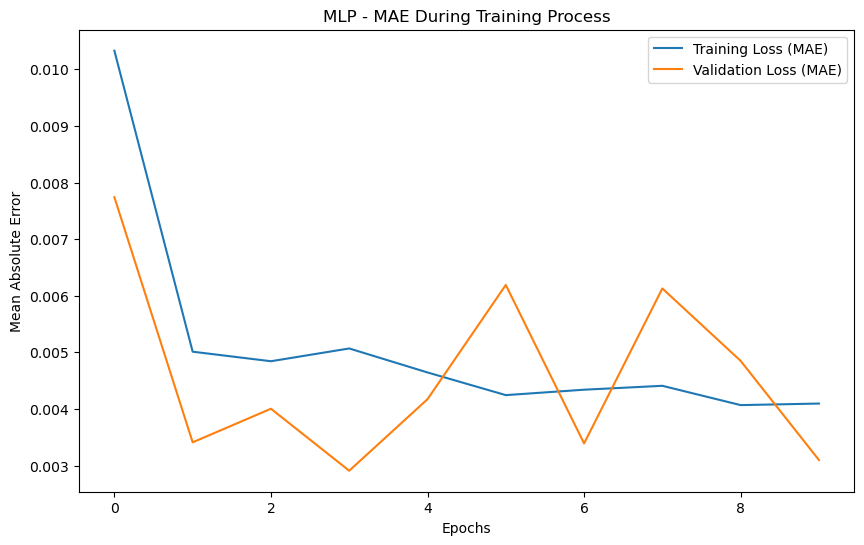

In [69]:
# 1. MLP Model
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(n_steps,)),
    Dense(32, activation='relu'),
    Dense(1)
])
mlp_model.compile(optimizer='adam', loss='mae')  # Use MAE as the loss function
train_and_plot(mlp_model, X.reshape((X.shape[0], X.shape[1])), y, "MLP")


**CNN Model**

Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0368 - val_loss: 0.0042
Epoch 2/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 3/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0053 - val_loss: 0.0037
Epoch 4/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 5/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 6/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 7/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 8/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0049 - val_loss: 0.0033
Epoch 9/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0043 - val_loss: 0.0108
Epoch 10/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0045 - val_loss: 0.0030


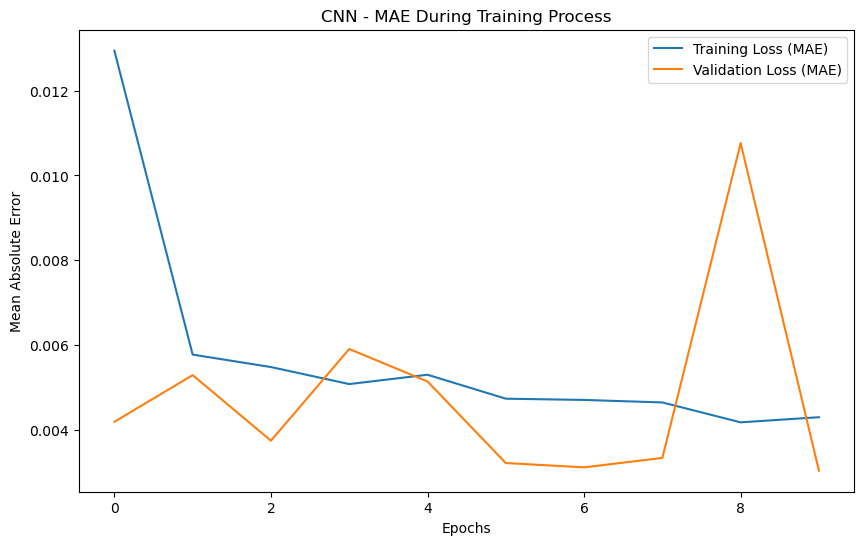

In [71]:
# 2. CNN Model
cnn_model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_steps, 1)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mae')
train_and_plot(cnn_model, X, y, "CNN")

**LTSM Model**

Epoch 1/10


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


441/441 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0960 - val_loss: 0.0045
Epoch 2/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 3/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 4/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 5/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 6/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 7/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 8/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 9/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 10/10
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0043 - val_loss: 0.0048


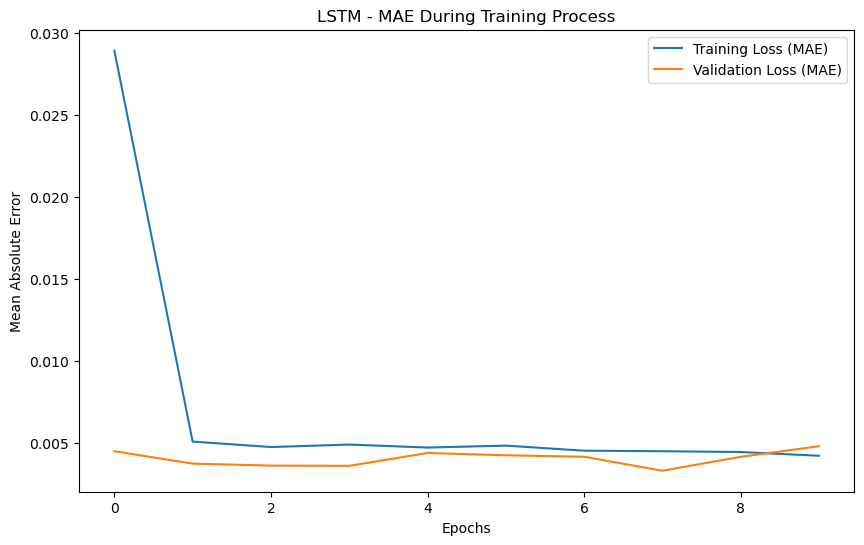

In [73]:
# 3. LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mae')
train_and_plot(lstm_model, X, y, "LSTM")

**Calculate MSE & MAE on Test dataset**

In [29]:
# Print results
for model_name, (mse, mae, _, _) in results.items():
    print(f"{model_name} - MSE: {mse:.5f}, MAE: {mae:.5f}")

MLP - MSE: 0.00078, MAE: 0.01942
CNN - MSE: 0.00151, MAE: 0.02978
LSTM - MSE: 0.00178, MAE: 0.03290


**Plot the results' graphs**

MLP - MSE: 0.00078, MAE: 0.01942


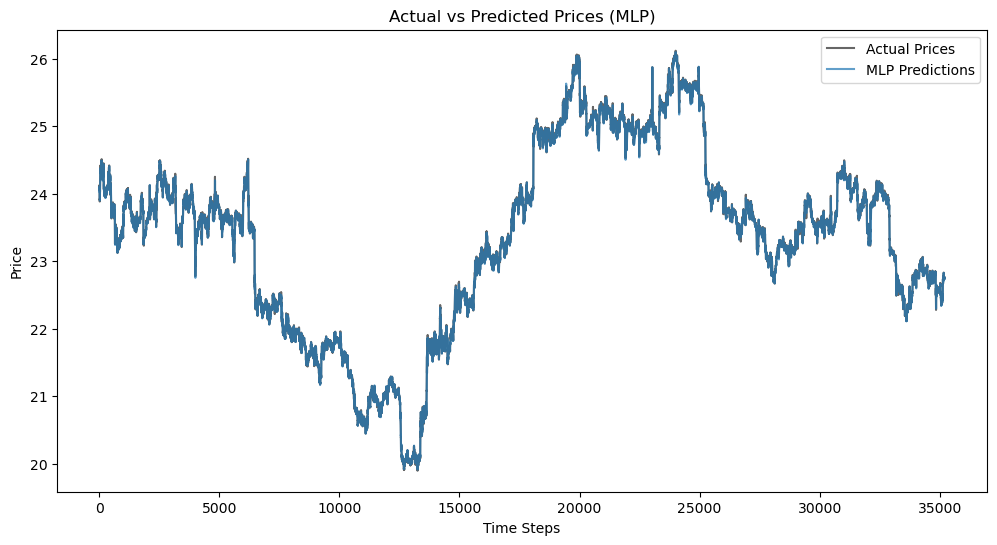

CNN - MSE: 0.00151, MAE: 0.02978


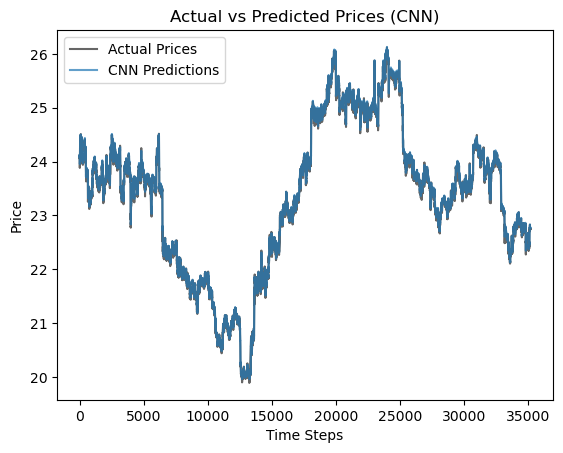

LSTM - MSE: 0.00178, MAE: 0.03290


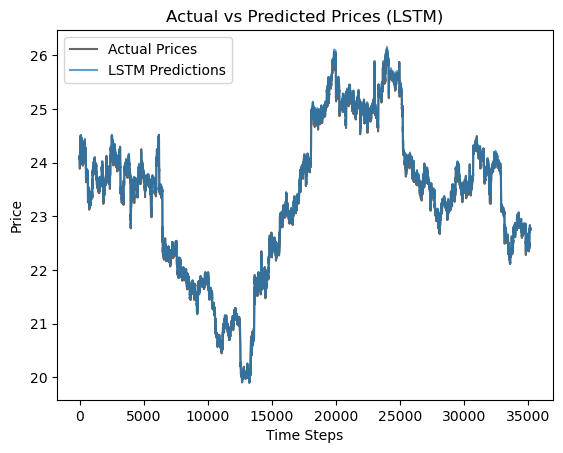

In [27]:
# Evaluate all models and plot results
plt.figure(figsize=(12, 6))

for model_name, (mse, mae, predicted_prices, actual_prices) in results.items():
    print(f"{model_name} - MSE: {mse:.5f}, MAE: {mae:.5f}")
    
    # Plot predictions for each model
    plt.plot(actual_prices, label=f'Actual Prices', color='black', alpha=0.6)
    plt.plot(predicted_prices, label=f'{model_name} Predictions', alpha=0.7)

    # Add title and labels for clarity
    plt.title(f'Actual vs Predicted Prices ({model_name})')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()
    plt.show()